In [4]:
import pandas as pd

In [146]:
models = ['13b-deduped', '6.7b-deduped', '2.7b-deduped', '1.3b-deduped', '800m-deduped', '350m-deduped', '125m-deduped', '19m-deduped']
checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
checkpoint_names = ['23m', '44m', '65m', '85m', '105m', '126m', '146m']
filepath = '/fsx/orz/memorization-evals'

In [148]:
import os
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [149]:
memorization_results = {}
for model in models:
    
    for checkpoint in tqdm(checkpoints[-1:], desc=model):
        filename = os.path.join(filepath, f'memorization_{model}_{checkpoint}.hdf')
        model_name = f'{model}-{checkpoint}'
        try:
            memorization_results[model_name] = pd.read_hdf(filename, key='memorization')
        except Exception as e:
            csv = pd.read_csv(os.path.join(filepath, f'memorization_results_{model}_{checkpoint}.csv'))
            csv.to_hdf(filename, key='memorization', index=False)
            memorization_results[model_name] = csv

13b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

6.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

2.7b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

1.3b-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

800m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

350m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

125m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

19m-deduped:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
model = AutoModelForCausalLM.from_pretrained(
            f"EleutherAI/pythia-1.3b-deduped",
            revision = f'step143000',
            use_cache=False, 
            cache_dir = '/fsx/orz/models'
        )

In [7]:
model = model.half().eval().cuda()

In [22]:
models = ['13b-deduped']
checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
for model in models:
    for checkpoint in tqdm(checkpoints, desc=model):
        AutoModelForCausalLM.from_pretrained(
            f"EleutherAI/pythia-{model}",
            revision = f'step{checkpoint}',
            use_cache=False, 
            cache_dir = '/fsx/orz/models'
        )

13b-deduped: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [20:20<00:00, 174.35s/it]


In [11]:
model = model.half().eval().cuda()

In [11]:
from megatron.data.data_utils import build_the_dataset

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [13]:
dataset = build_the_dataset(
        data_prefix = '/fsx/pile/pile_20B_tokenizer_text_document',
        name = 'train_0',
        data_impl='mmap',
        num_samples=131727360,
        seq_length=2048,
        seed=1234,
        skip_warmup=True,
        build_index_mappings=False
    )

    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...
    train_0:
     no. of documents:210604984


In [14]:
import numpy as np

In [15]:
idx_path = "/fsx/pile/pile_20B_tokenizer_text_document_test_0_indexmap_10292ns"
dataset.doc_idx = np.load(f"{idx_path}_2048sl_1234s_doc_idx.npy")
dataset.sample_idx = np.load(f"{idx_path}_2048sl_1234s_sample_idx.npy")
dataset.shuffle_idx = np.load(f"{idx_path}_2048sl_1234s_shuffle_idx.npy")

In [16]:
dataset.shuffle_idx_len = dataset.shuffle_idx.shape[0] - 1
dataset.sample_idx_len = dataset.sample_idx.shape[0] - 1

In [29]:
!pip3 install pandarallel

     |████████████████████████████████| 110 kB 29.8 MB/s eta 0:00:01
  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16449 sha256=420d869fee4d17f949725f8fd5b680063135fd0601c69f976f57c811e13e68e0
  Stored in directory: /admin/home-orz/.cache/pip/wheels/16/f5/91/d7efa7c4911ae1cf1aff825f902382eb69a1855f9987a7d17c
Successfully built pandarallel


In [32]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [51]:
for model in models:
    data = memorization_results[f'{model}-143000']
    data_acc1 = data[data['accuracy'] == 1]
    print((len(data_acc1)*100)/len(data))
    data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
    data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')

1.6269162478146852


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


1.4484327196241258


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


1.143928239729021


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


0.9381296437937063


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.8578323044143357


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


0.6626563865821679


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


0.4709851671765734


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


0.3168385325611888


/fsx/orz/memorization/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/tmp/ipykernel_1358952/3470156160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_acc1['tokens'] = data_acc1['index'].parallel_apply(lambda x:dataset[x]['text'][:64].tolist())
/tmp/ipykernel_1358952/3470156160.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['tokens'], dtype='object')]

  data_acc1.to_hdf(f"/fsx/orz/memorized-data/{model}.hdf", key='memorization')


In [53]:
memorized_19m = memorization_results['19m-143000']
memorized_19m = memorized_19m[memorized_19m['accuracy'] == 1]
memorized_13b = memorization_results['13b-143000']
memorized_13b = memorized_13b[memorized_13b['accuracy'] == 1]

In [150]:
memorized_fracs = []
for model in models:
    memorized_data = memorization_results[f'{model}-143000']
    memorized_data = memorized_data[memorized_data['accuracy'] == 1]
    memorized_fracs.append(len(memorized_data)/len(memorization_results[f'{model}-143000']))

In [151]:
memorized_fracs = [memorized_fracs[i] for i in range(7, -1, -1)]

In [152]:
def update_params(size = 25):
    params = {
        'legend.fontsize': 'large',
        'figure.figsize': (15,10),
        'axes.labelsize': size,
        'axes.titlesize': size,
        'xtick.labelsize': size*0.75,
        'ytick.labelsize': size*0.75,
        'axes.titlepad': 25,
        'font.family':'sans-serif',
        'font.weight':'bold',
    }
    plt.rcParams.update(params)
update_params()

Text(0.5, 1.0, '146m Deduped Checkpoint Memorized Sequences')

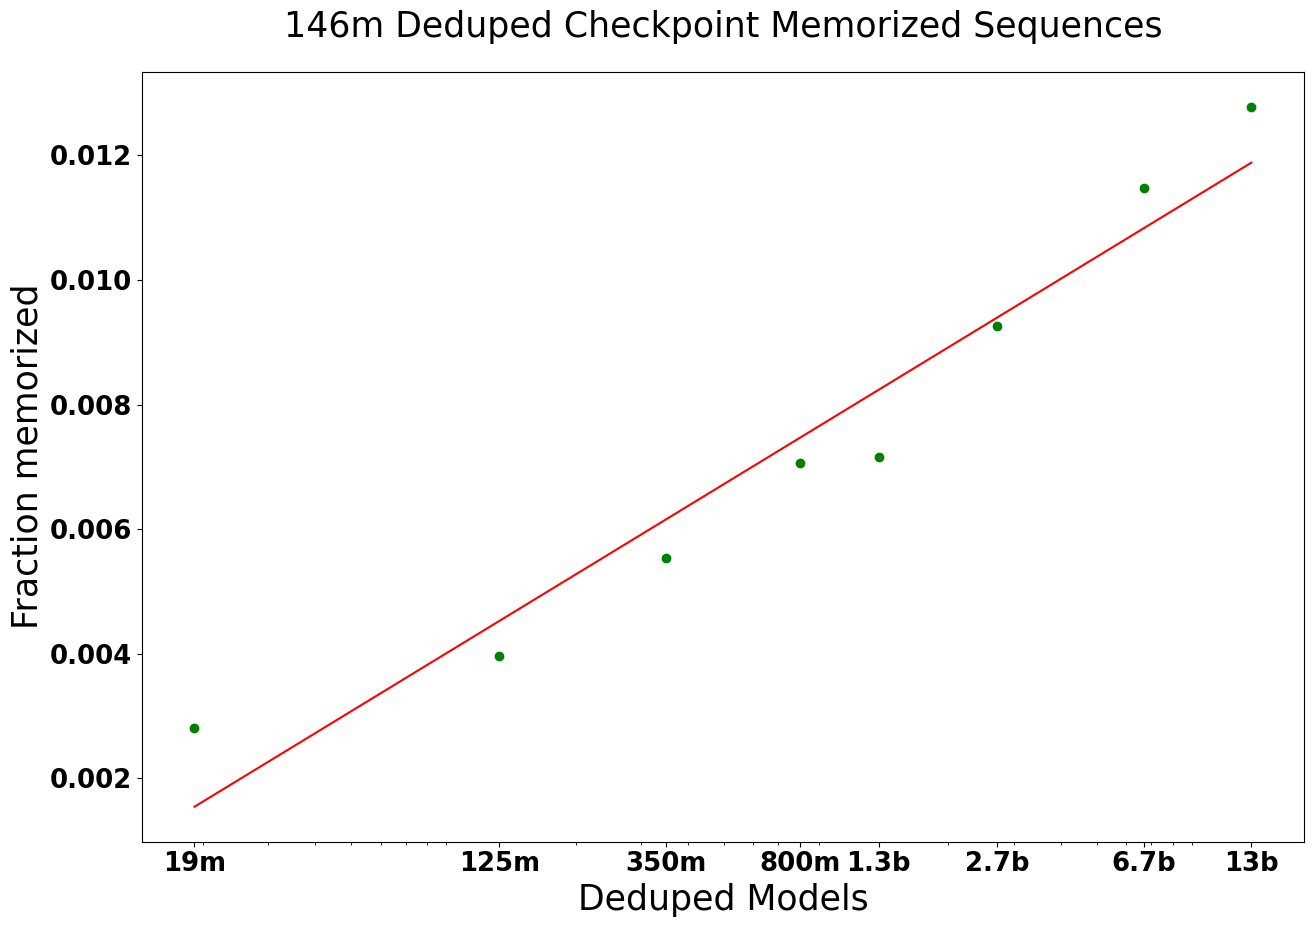

In [155]:
import matplotlib.pyplot as plt
from matplotlib import scale
ticks = [13000, 6700, 2700, 1300, 800, 350, 125, 19]
ticks = [ticks[i] for i in range(len(ticks)-1, -1, -1)]
ax = plt.scatter(ticks , memorized_fracs, color='green')
log_ticks = np.log(ticks)
m, b = np.polyfit(log_ticks, memorized_fracs, 1)
plt.plot([ticks[0], ticks[-1]], [np.log(ticks[0])*m + b, np.log(ticks[-1])*m + b], color = 'red')
plt.xscale("log")
plt.xticks(ticks = ticks, labels=[models[i].split('-')[0] for i in range(7, -1, -1)])
plt.xlabel("Deduped Models")
plt.ylabel("Fraction memorized")
plt.title("146m Deduped Checkpoint Memorized Sequences")

In [137]:
memorized_fracs[1]

0.004709851671765734

In [138]:
m*np.log(ticks[1]) + b

0.005424575802296957

In [117]:
np.e

2.718281828459045

In [1]:
import boto3

In [4]:
s3_resource = boto3.client('s3')

In [7]:
s3_resource.put_object(
    Body = '1,0.3\n2,0.8\n'.encode(),
    Bucket = 's-eai-neox',
    Key = 'memorization-evals/temp.csv'
)

{'ResponseMetadata': {'RequestId': 'A3551C2D9VRDZJRY',
  'HostId': 'U+NxATqKWGX3iiE8BJ/DoGty2NSHQn24S8YKqkAo44OfKOu56GZD+yAnV0QpFMOmuQptlcdevPY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'U+NxATqKWGX3iiE8BJ/DoGty2NSHQn24S8YKqkAo44OfKOu56GZD+yAnV0QpFMOmuQptlcdevPY=',
   'x-amz-request-id': 'A3551C2D9VRDZJRY',
   'date': 'Sun, 01 Jan 2023 07:12:35 GMT',
   'x-amz-version-id': 'kPEyYhr2Ml3m5IO3CCjjbtBqvA9XsFlQ',
   'etag': '"b050b2c956f8ab6963e6aa95655843ee"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b050b2c956f8ab6963e6aa95655843ee"',
 'VersionId': 'kPEyYhr2Ml3m5IO3CCjjbtBqvA9XsFlQ'}